In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import json
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from matplotlib.ticker import FormatStrFormatter
import warnings
warnings.filterwarnings("ignore", category=UserWarning) # Avoid user warning caused by scipy

## Functions for evaluation and plotting

In [2]:
def generate_df(dict, group_name):
    
    metric_types = list(dict.keys())
    print(metric_types)
    
    data = {
        "group": [group_name] * len(dict[metric_types[0]]["results"]),
    }

    for metric_type in metric_types:
        for t in ["id"] + types: 
            if t in dict[metric_type]["results"][0].keys():
                data[t] = [d[t] for d in dict[ metric_type]["results"]]
    #print(data)
    df = pd.DataFrame(data)

    return df

In [3]:
# Function to compute statistical features
def compute_features(probabilities):
    return {
        "mean": np.mean(probabilities),
        "std_dev": np.std(probabilities),
        "min": np.min(probabilities),
        "max": np.max(probabilities),
        "25th_percentile": np.percentile(probabilities, 25),
        "50th_percentile": np.percentile(probabilities, 50),  # Median
        "75th_percentile": np.percentile(probabilities, 75),
        "mean-min-diff": np.absolute(np.mean(probabilities) - np.min(probabilities)),
        "mean-max-diff": np.absolute(np.mean(probabilities) - np.max(probabilities))
    }

In [4]:
def apply_svm_with_pca(df_final):
    
    svm = SVC(kernel='linear')
    
    # Lists to store true labels and predictions
    all_y_true = []
    all_y_pred = []
    
    X, y = df_final.drop(["group", "datapoint_id"], axis=1), df_final["group"]
    
    # Apply PCA for dimensionality reduction (keep 5 components)
    pca = PCA(n_components=5)
    X_pca = pca.fit_transform(X)  # Fit PCA on the data and transform the data
    
    # Fit the SVM model on the dimensional reduced data
    svm.fit(X_pca, y)
    
    # Make predictions on the dimensional reduced data
    y_pred = svm.predict(X_pca)
    
    # Calculate accuracy
    accuracy = accuracy_score(y, y_pred)
    
    # Print accuracy
    print(f"Accuracy of fit: {accuracy:.4f}")

    # Store true labels and predictions
    all_y_true.extend(y.values)
    all_y_pred.extend(y_pred)

    return all_y_true, all_y_pred


def generate_cm(df_final, all_y_true, all_y_pred, name):

    # Get confuction matrix from predictions and true labels
    cm = confusion_matrix(all_y_true, all_y_pred, labels=df_final["group"].unique(), normalize="all")
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=df_final["group"].unique())
    
    # Plot the confusion matrix
    if len(df_final["group"].unique()) == 2:
        disp.plot(cmap=plt.cm.Blues, xticks_rotation=0)
    else: 
        disp.plot(cmap=plt.cm.Blues, xticks_rotation=20)
    plt.title(name, fontsize=20)  # Title font size
    plt.xlabel("Predicted Label", fontsize=16)  # X-axis label font size
    plt.ylabel("True Label", fontsize=16)       # Y-axis label font size
    plt.xticks(fontsize=14)                     # X-axis tick font size
    plt.yticks(fontsize=14)                     # Y-axis tick font size
    
    # Customize font size of matrix number
    for text in disp.text_.ravel():
        text.set_fontsize(16) 
    # Customize font size of colorbar
    cbar = disp.im_.colorbar
    cbar.ax.tick_params(labelsize=14)
    cbar.ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))

    save_plot = False

    if save_plot:
        plt.tight_layout()
        plt.savefig("CM_" + name.replace(" ", ""), dpi=100, bbox_inches='tight')


def evalaute_and_plot(df_final, name):
    all_y_true, all_y_pred = apply_svm_with_pca(df_final)
    generate_cm(df_final, all_y_true, all_y_pred, name)

## LLogNet (Full)

['source_grounding', 'step_entailment', 'chain_entailment']
['source_grounding', 'step_entailment', 'chain_entailment']
['source_grounding', 'step_entailment', 'chain_entailment']
['source_grounding', 'step_entailment', 'chain_entailment']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32 entries, 0 to 31
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   group                         32 non-null     object
 1   id                            32 non-null     int64 
 2   conc_agreement_probs          32 non-null     object
 3   prem_agreement_probs          32 non-null     object
 4   ent_probs                     32 non-null     object
 5   non_cont_probs                32 non-null     object
 6   weighted_ent_chain_probs      32 non-null     object
 7   weighted_noncont_chain_probs  32 non-null     object
dtypes: int64(1), object(7)
memory usage: 2.1+ KB
None
<class 'pandas.core.fra

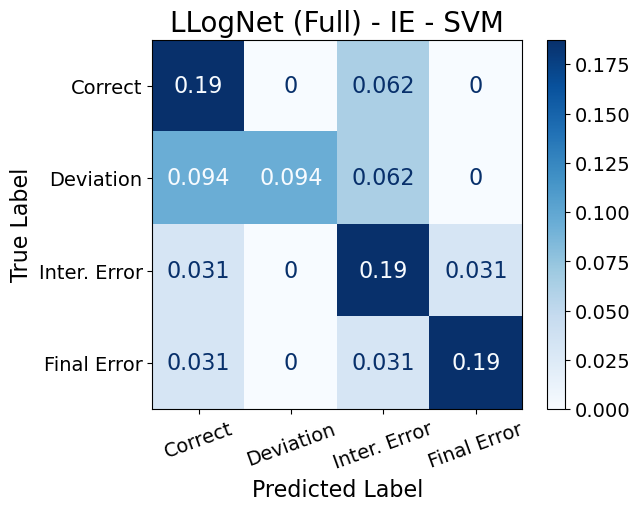

In [5]:
dict_IE_corr = json.load(open("IE/correct/evaluation_llognet/infer_emotion.json"))
dict_IE_source_dev = json.load(open("IE/source_dev/evaluation_llognet/infer_emotion.json"))
dict_IE_wrong_inter = json.load(open("IE/inter_err/evaluation_llognet/infer_emotion.json"))
dict_IE_wrong_final = json.load(open("IE/final_err/evaluation_llognet/infer_emotion.json"))

types = [
    "ent_probs", 
    "non_cont_probs", 
    'weighted_ent_chain_probs', 
    'weighted_noncont_chain_probs',
    'conc_agreement_probs',
    'prem_agreement_probs'
]

# Convert data to a DataFrame
df_corr = generate_df(dict_IE_corr, "Correct")
df_source_dev = generate_df(dict_IE_source_dev, "Deviation")
df_wrong_inter = generate_df(dict_IE_wrong_inter, "Inter. Error")
df_wrong_final = generate_df(dict_IE_wrong_final, "Final Error")
df = pd.concat([df_corr, df_source_dev, df_wrong_inter, df_wrong_final], ignore_index=True)
print(df.info())

# Apply the compute_features function to each row
aggregated_columns = []
for t in types:
    features = df[t].apply(compute_features)
    # Convert the list of dictionaries to a DataFrame
    features_df = pd.DataFrame(features.tolist())
    features_df.columns = [f"{t}_{name}" for name in features_df.columns]
    aggregated_columns.append(features_df)

df_final = pd.concat([df["group"]] + aggregated_columns, axis=1)
df_final["datapoint_id"] = df_final.groupby("group").cumcount()
grouped = df_final.groupby("datapoint_id")
print(df_final.info())

evalaute_and_plot(df_final, "LLogNet (Full) - IE - SVM")

['source_grounding', 'step_entailment', 'chain_entailment']
['source_grounding', 'step_entailment', 'chain_entailment']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16 entries, 0 to 15
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   group                         16 non-null     object
 1   id                            16 non-null     int64 
 2   conc_agreement_probs          16 non-null     object
 3   prem_agreement_probs          16 non-null     object
 4   ent_probs                     16 non-null     object
 5   non_cont_probs                16 non-null     object
 6   weighted_ent_chain_probs      16 non-null     object
 7   weighted_noncont_chain_probs  16 non-null     object
dtypes: int64(1), object(7)
memory usage: 1.1+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16 entries, 0 to 15
Data columns (total 56 columns):
 #   Column                             

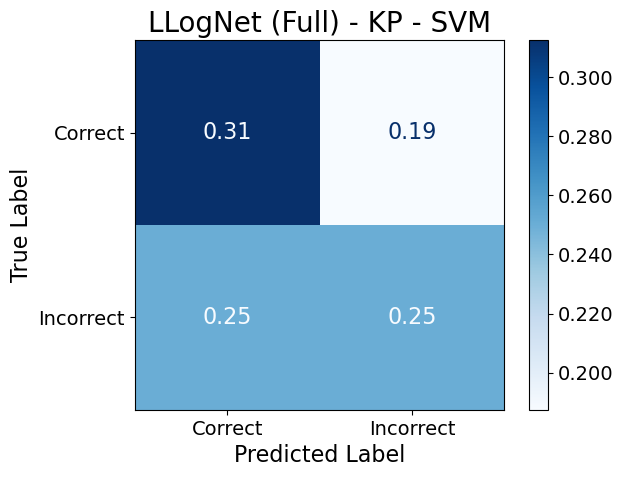

In [6]:
dict_KP_corr = json.load(open("KP/correct/evaluation_llognet/knowledge_perception.json"))
dict_KP_incorr = json.load(open("KP/incorrect/evaluation_llognet/knowledge_perception.json"))

types = [
    "ent_probs", 
    "non_cont_probs", 
    'weighted_ent_chain_probs', 
    'weighted_noncont_chain_probs',
    'conc_agreement_probs',
    'prem_agreement_probs'
]

# Convert data to a DataFrame
df_corr = generate_df(dict_KP_corr, "Correct")
df_incorr = generate_df(dict_KP_incorr, "Incorrect")
df = pd.concat([df_corr, df_incorr], ignore_index=True)
print(df.info())

# Apply the compute_features function to each row
aggregated_columns = []
for t in types:
    features = df[t].apply(compute_features)
    # Convert the list of dictionaries to a DataFrame
    features_df = pd.DataFrame(features.tolist())
    features_df.columns = [f"{t}_{name}" for name in features_df.columns]
    aggregated_columns.append(features_df)

df_final = pd.concat([df["group"]] + aggregated_columns, axis=1)
df_final["datapoint_id"] = df_final.groupby("group").cumcount()
grouped = df_final.groupby("datapoint_id")
print(df_final.info())

evalaute_and_plot(df_final, "LLogNet (Full) - KP - SVM")

## LLogNet (Chain)

['source_grounding', 'step_entailment', 'chain_entailment']
['source_grounding', 'step_entailment', 'chain_entailment']
['source_grounding', 'step_entailment', 'chain_entailment']
['source_grounding', 'step_entailment', 'chain_entailment']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32 entries, 0 to 31
Data columns (total 4 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   group                         32 non-null     object
 1   id                            32 non-null     int64 
 2   weighted_ent_chain_probs      32 non-null     object
 3   weighted_noncont_chain_probs  32 non-null     object
dtypes: int64(1), object(3)
memory usage: 1.1+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32 entries, 0 to 31
Data columns (total 20 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0

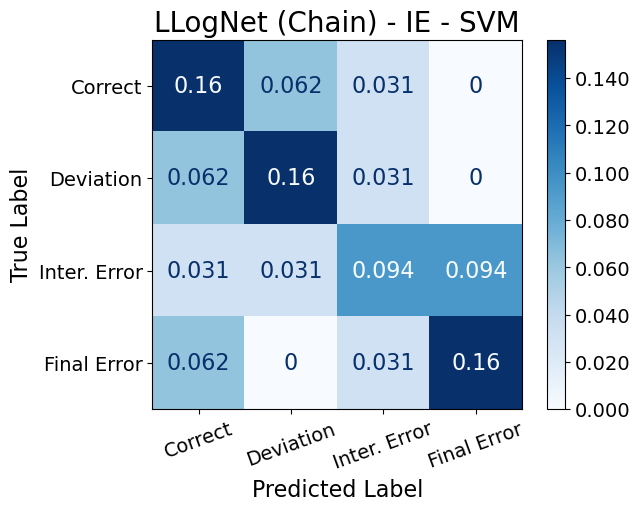

In [7]:
dict_IE_corr = json.load(open("IE/correct/evaluation_llognet/infer_emotion.json"))
dict_IE_source_dev = json.load(open("IE/source_dev/evaluation_llognet/infer_emotion.json"))
dict_IE_wrong_inter = json.load(open("IE/inter_err/evaluation_llognet/infer_emotion.json"))
dict_IE_wrong_final = json.load(open("IE/final_err/evaluation_llognet/infer_emotion.json"))

types = [
    'weighted_ent_chain_probs', 
    'weighted_noncont_chain_probs',
]

# Convert data to a DataFrame
df_corr = generate_df(dict_IE_corr, "Correct")
df_source_dev = generate_df(dict_IE_source_dev, "Deviation")
df_wrong_inter = generate_df(dict_IE_wrong_inter, "Inter. Error")
df_wrong_final = generate_df(dict_IE_wrong_final, "Final Error")
df = pd.concat([df_corr, df_source_dev, df_wrong_inter, df_wrong_final], ignore_index=True)
print(df.info())

# Apply the compute_features function to each row
aggregated_columns = []
for t in types:
    features = df[t].apply(compute_features)
    # Convert the list of dictionaries to a DataFrame
    features_df = pd.DataFrame(features.tolist())
    features_df.columns = [f"{t}_{name}" for name in features_df.columns]
    aggregated_columns.append(features_df)

df_final = pd.concat([df["group"]] + aggregated_columns, axis=1)
df_final["datapoint_id"] = df_final.groupby("group").cumcount()
grouped = df_final.groupby("datapoint_id")
print(df_final.info())

evalaute_and_plot(df_final, "LLogNet (Chain) - IE - SVM")

['source_grounding', 'step_entailment', 'chain_entailment']
['source_grounding', 'step_entailment', 'chain_entailment']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16 entries, 0 to 15
Data columns (total 4 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   group                         16 non-null     object
 1   id                            16 non-null     int64 
 2   weighted_ent_chain_probs      16 non-null     object
 3   weighted_noncont_chain_probs  16 non-null     object
dtypes: int64(1), object(3)
memory usage: 640.0+ bytes
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16 entries, 0 to 15
Data columns (total 20 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   group                                         16 non-null     object 
 1   weighted_ent_chain_probs_mean        

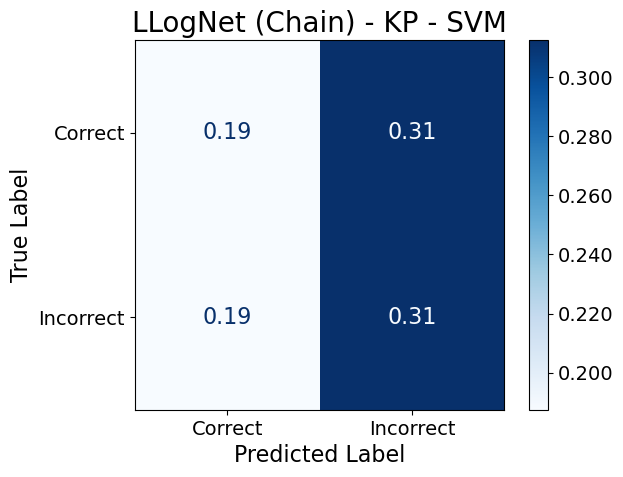

In [8]:
dict_KP_corr = json.load(open("KP/correct/evaluation_llognet/knowledge_perception.json"))
dict_KP_incorr = json.load(open("KP/incorrect/evaluation_llognet/knowledge_perception.json"))

types = [
    'weighted_ent_chain_probs', 
    'weighted_noncont_chain_probs',
]

# Convert data to a DataFrame
df_corr = generate_df(dict_KP_corr, "Correct")
df_incorr = generate_df(dict_KP_incorr, "Incorrect")
df = pd.concat([df_corr, df_incorr], ignore_index=True)
print(df.info())

# Apply the compute_features function to each row
aggregated_columns = []
for t in types:
    features = df[t].apply(compute_features)
    # Convert the list of dictionaries to a DataFrame
    features_df = pd.DataFrame(features.tolist())
    features_df.columns = [f"{t}_{name}" for name in features_df.columns]
    aggregated_columns.append(features_df)

df_final = pd.concat([df["group"]] + aggregated_columns, axis=1)
df_final["datapoint_id"] = df_final.groupby("group").cumcount()
grouped = df_final.groupby("datapoint_id")
print(df_final.info())

evalaute_and_plot(df_final, "LLogNet (Chain) - KP - SVM")

## LLogNet (Step)

['source_grounding', 'step_entailment', 'chain_entailment']
['source_grounding', 'step_entailment', 'chain_entailment']
['source_grounding', 'step_entailment', 'chain_entailment']
['source_grounding', 'step_entailment', 'chain_entailment']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32 entries, 0 to 31
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   group           32 non-null     object
 1   id              32 non-null     int64 
 2   ent_probs       32 non-null     object
 3   non_cont_probs  32 non-null     object
dtypes: int64(1), object(3)
memory usage: 1.1+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32 entries, 0 to 31
Data columns (total 20 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   group                           32 non-null     object 
 1   ent_probs_mean                  32 non-null     

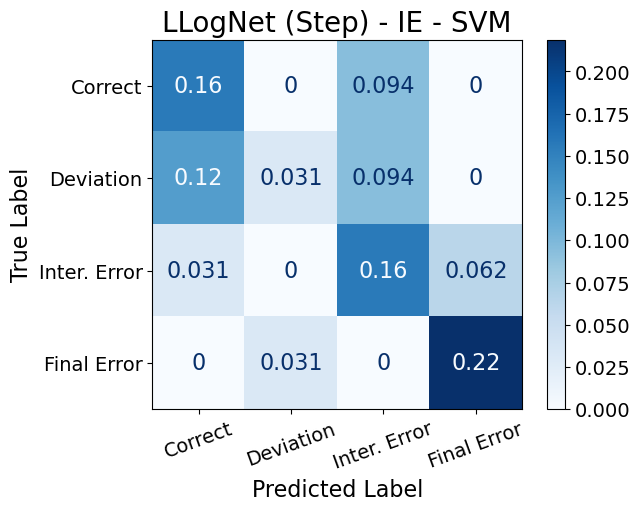

In [9]:
dict_IE_corr = json.load(open("IE/correct/evaluation_llognet/infer_emotion.json"))
dict_IE_source_dev = json.load(open("IE/source_dev/evaluation_llognet/infer_emotion.json"))
dict_IE_wrong_inter = json.load(open("IE/inter_err/evaluation_llognet/infer_emotion.json"))
dict_IE_wrong_final = json.load(open("IE/final_err/evaluation_llognet/infer_emotion.json"))

types = [
    "ent_probs", 
    "non_cont_probs", 
]

# Convert data to a DataFrame
df_corr = generate_df(dict_IE_corr, "Correct")
df_source_dev = generate_df(dict_IE_source_dev, "Deviation")
df_wrong_inter = generate_df(dict_IE_wrong_inter, "Inter. Error")
df_wrong_final = generate_df(dict_IE_wrong_final, "Final Error")
df = pd.concat([df_corr, df_source_dev, df_wrong_inter, df_wrong_final], ignore_index=True)
print(df.info())

# Apply the compute_features function to each row
aggregated_columns = []
for t in types:
    features = df[t].apply(compute_features)
    # Convert the list of dictionaries to a DataFrame
    features_df = pd.DataFrame(features.tolist())
    features_df.columns = [f"{t}_{name}" for name in features_df.columns]
    aggregated_columns.append(features_df)

df_final = pd.concat([df["group"]] + aggregated_columns, axis=1)
df_final["datapoint_id"] = df_final.groupby("group").cumcount()
grouped = df_final.groupby("datapoint_id")
print(df_final.info())

evalaute_and_plot(df_final, "LLogNet (Step) - IE - SVM")

['source_grounding', 'step_entailment', 'chain_entailment']
['source_grounding', 'step_entailment', 'chain_entailment']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16 entries, 0 to 15
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   group           16 non-null     object
 1   id              16 non-null     int64 
 2   ent_probs       16 non-null     object
 3   non_cont_probs  16 non-null     object
dtypes: int64(1), object(3)
memory usage: 640.0+ bytes
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16 entries, 0 to 15
Data columns (total 20 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   group                           16 non-null     object 
 1   ent_probs_mean                  16 non-null     float64
 2   ent_probs_std_dev               16 non-null     float64
 3   ent_probs_min                   16 non-nu

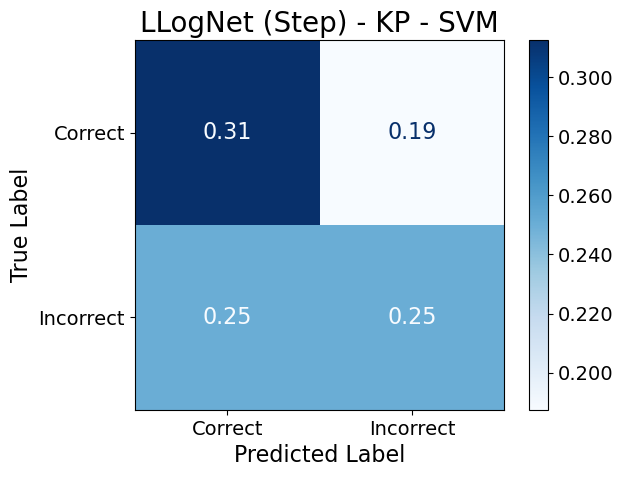

In [10]:
dict_KP_corr = json.load(open("KP/correct/evaluation_llognet/knowledge_perception.json"))
dict_KP_incorr = json.load(open("KP/incorrect/evaluation_llognet/knowledge_perception.json"))

types = [
    "ent_probs", 
    "non_cont_probs",
]

# Convert data to a DataFrame
df_corr = generate_df(dict_KP_corr, "Correct")
df_incorr = generate_df(dict_KP_incorr, "Incorrect")
df = pd.concat([df_corr, df_incorr], ignore_index=True)
print(df.info())

# Apply the compute_features function to each row
aggregated_columns = []
for t in types:
    features = df[t].apply(compute_features)
    # Convert the list of dictionaries to a DataFrame
    features_df = pd.DataFrame(features.tolist())
    features_df.columns = [f"{t}_{name}" for name in features_df.columns]
    aggregated_columns.append(features_df)

df_final = pd.concat([df["group"]] + aggregated_columns, axis=1)
df_final["datapoint_id"] = df_final.groupby("group").cumcount()
grouped = df_final.groupby("datapoint_id")
print(df_final.info())

evalaute_and_plot(df_final, "LLogNet (Step) - KP - SVM")

## ROSCOE

['semantic_alignment', 'semantic_similarity', 'logical_inference', 'language_coherence']
['semantic_alignment', 'semantic_similarity', 'logical_inference', 'language_coherence']
['semantic_alignment', 'semantic_similarity', 'logical_inference', 'language_coherence']
['semantic_alignment', 'semantic_similarity', 'logical_inference', 'language_coherence']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32 entries, 0 to 31
Data columns (total 4 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   group                      32 non-null     object
 1   id                         32 non-null     int64 
 2   self_consistency_scores    32 non-null     object
 3   source_consistency_scores  32 non-null     object
dtypes: int64(1), object(3)
memory usage: 1.1+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32 entries, 0 to 31
Data columns (total 20 columns):
 #   Column                                     Non-Nu

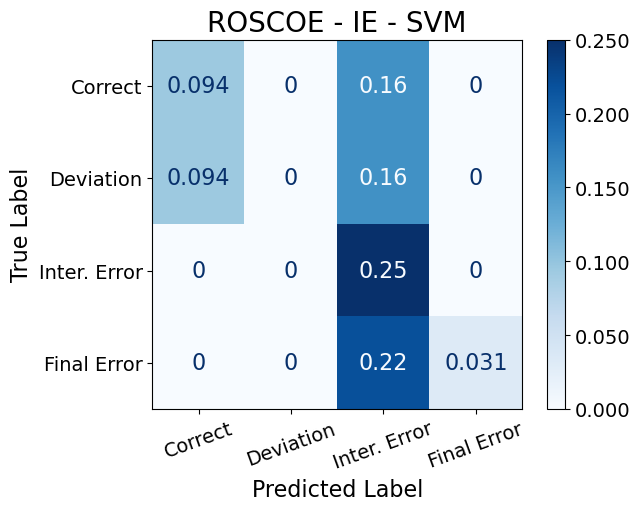

In [11]:
dict_IE_corr = json.load(open("IE/correct/evaluation_roscoe/infer_emotion.json"))
dict_IE_source_dev = json.load(open("IE/source_dev/evaluation_roscoe/infer_emotion.json"))
dict_IE_wrong_inter = json.load(open("IE/inter_err/evaluation_roscoe/infer_emotion.json"))
dict_IE_wrong_final = json.load(open("IE/final_err/evaluation_roscoe/infer_emotion.json"))

types = [
    "self_consistency_scores",
    "source_consistency_scores"
]

# Convert data to a DataFrame
df_corr = generate_df(dict_IE_corr, "Correct")
df_source_dev = generate_df(dict_IE_source_dev, "Deviation")
df_wrong_inter = generate_df(dict_IE_wrong_inter, "Inter. Error")
df_wrong_final = generate_df(dict_IE_wrong_final, "Final Error")
df = pd.concat([df_corr, df_source_dev, df_wrong_inter, df_wrong_final], ignore_index=True)
print(df.info())

# Apply the compute_features function to each row
aggregated_columns = []
for t in types:
    features = df[t].apply(compute_features)
    # Convert the list of dictionaries to a DataFrame
    features_df = pd.DataFrame(features.tolist())
    features_df.columns = [f"{t}_{name}" for name in features_df.columns]
    aggregated_columns.append(features_df)

df_final = pd.concat([df["group"]] + aggregated_columns, axis=1)
df_final["datapoint_id"] = df_final.groupby("group").cumcount()
grouped = df_final.groupby("datapoint_id")
print(df_final.info())

evalaute_and_plot(df_final, "ROSCOE - IE - SVM")

['semantic_alignment', 'semantic_similarity', 'logical_inference', 'language_coherence']
['semantic_alignment', 'semantic_similarity', 'logical_inference', 'language_coherence']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16 entries, 0 to 15
Data columns (total 4 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   group                      16 non-null     object
 1   id                         16 non-null     int64 
 2   self_consistency_scores    16 non-null     object
 3   source_consistency_scores  16 non-null     object
dtypes: int64(1), object(3)
memory usage: 640.0+ bytes
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16 entries, 0 to 15
Data columns (total 20 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   group                                      16 non-null     object 
 1   self_c

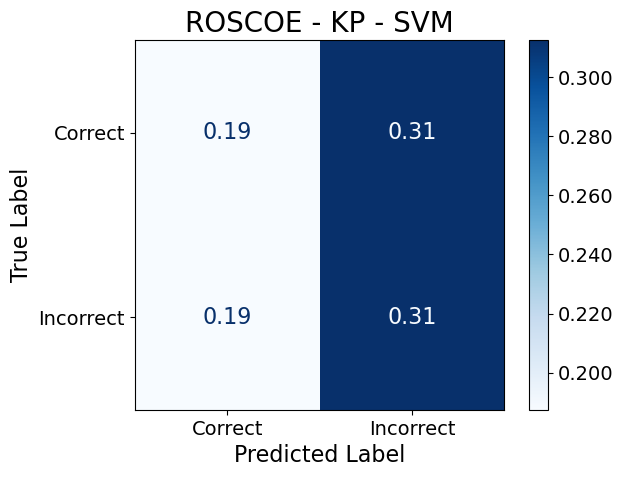

In [12]:
dict_KP_corr = json.load(open("KP/correct/evaluation_roscoe/knowledge_perception.json"))
dict_KP_incorr = json.load(open("KP/incorrect/evaluation_roscoe/knowledge_perception.json"))

types = [
    "self_consistency_scores",
    "source_consistency_scores"
]

# Convert data to a DataFrame
df_corr = generate_df(dict_KP_corr, "Correct")
df_incorr = generate_df(dict_KP_incorr, "Incorrect")
df = pd.concat([df_corr, df_incorr], ignore_index=True)
print(df.info())

# Apply the compute_features function to each row
aggregated_columns = []
for t in types:
    features = df[t].apply(compute_features)
    # Convert the list of dictionaries to a DataFrame
    features_df = pd.DataFrame(features.tolist())
    features_df.columns = [f"{t}_{name}" for name in features_df.columns]
    aggregated_columns.append(features_df)

df_final = pd.concat([df["group"]] + aggregated_columns, axis=1)
df_final["datapoint_id"] = df_final.groupby("group").cumcount()
grouped = df_final.groupby("datapoint_id")
print(df_final.info())

evalaute_and_plot(df_final, "ROSCOE - KP - SVM")

## ReCEval

['rcu']
['rcu']
['rcu']
['rcu']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32 entries, 0 to 31
Data columns (total 6 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   group                           32 non-null     object
 1   id                              32 non-null     int64 
 2   intra-correctness_scores (k=0)  32 non-null     object
 3   intra-correctness_scores (k=4)  32 non-null     object
 4   intra-correctness_scores (k=8)  32 non-null     object
 5   inter-correctness_scores        32 non-null     object
dtypes: int64(1), object(5)
memory usage: 1.6+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32 entries, 0 to 31
Data columns (total 38 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   group                                           32 non-null     objec

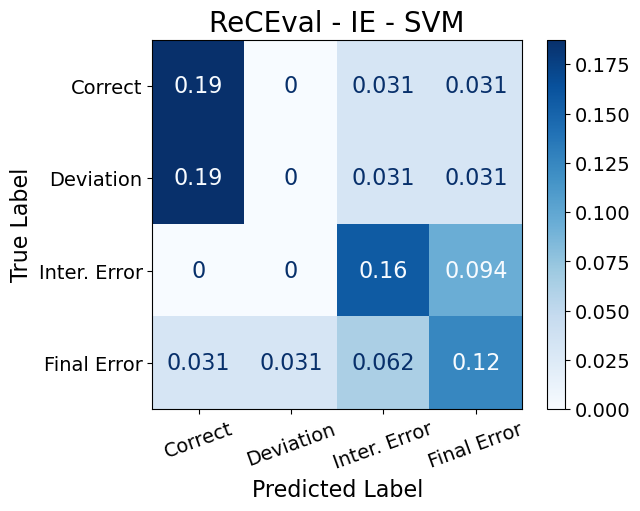

In [13]:
dict_IE_corr = json.load(open("IE/correct/evaluation_receval/infer_emotion.json"))
dict_IE_source_dev = json.load(open("IE/source_dev/evaluation_receval/infer_emotion.json"))
dict_IE_wrong_inter = json.load(open("IE/inter_err/evaluation_receval/infer_emotion.json"))
dict_IE_wrong_final = json.load(open("IE/final_err/evaluation_receval/infer_emotion.json"))

types = [
    "intra-correctness_scores (k=0)",
    "intra-correctness_scores (k=4)",
    "intra-correctness_scores (k=8)",
    "inter-correctness_scores"
]

# Convert data to a DataFrame
df_corr = generate_df(dict_IE_corr, "Correct")
df_source_dev = generate_df(dict_IE_source_dev, "Deviation")
df_wrong_inter = generate_df(dict_IE_wrong_inter, "Inter. Error")
df_wrong_final = generate_df(dict_IE_wrong_final, "Final Error")
df = pd.concat([df_corr, df_source_dev, df_wrong_inter, df_wrong_final], ignore_index=True)
print(df.info())

# Apply the compute_features function to each row
aggregated_columns = []
for t in types:
    features = df[t].apply(compute_features)
    # Convert the list of dictionaries to a DataFrame
    features_df = pd.DataFrame(features.tolist())
    features_df.columns = [f"{t}_{name}" for name in features_df.columns]
    aggregated_columns.append(features_df)

df_final = pd.concat([df["group"]] + aggregated_columns, axis=1)
df_final["datapoint_id"] = df_final.groupby("group").cumcount()
grouped = df_final.groupby("datapoint_id")
print(df_final.info())

evalaute_and_plot(df_final, "ReCEval - IE - SVM")

['rcu']
['rcu']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16 entries, 0 to 15
Data columns (total 6 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   group                           16 non-null     object
 1   id                              16 non-null     int64 
 2   intra-correctness_scores (k=0)  16 non-null     object
 3   intra-correctness_scores (k=4)  16 non-null     object
 4   intra-correctness_scores (k=8)  16 non-null     object
 5   inter-correctness_scores        16 non-null     object
dtypes: int64(1), object(5)
memory usage: 896.0+ bytes
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16 entries, 0 to 15
Data columns (total 38 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   group                                           16 non-null     object 
 1   int

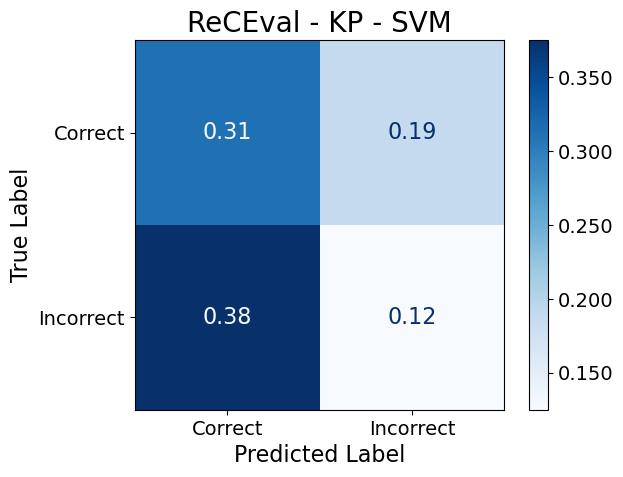

In [14]:
dict_KP_corr = json.load(open("KP/correct/evaluation_receval/knowledge_perception.json"))
dict_KP_incorr = json.load(open("KP/incorrect/evaluation_receval/knowledge_perception.json"))

types = [
    "intra-correctness_scores (k=0)",
    "intra-correctness_scores (k=4)",
    "intra-correctness_scores (k=8)",
    "inter-correctness_scores"
]

# Convert data to a DataFrame
df_corr = generate_df(dict_KP_corr, "Correct")
df_incorr = generate_df(dict_KP_incorr, "Incorrect")
df = pd.concat([df_corr, df_incorr], ignore_index=True)
print(df.info())

# Apply the compute_features function to each row
aggregated_columns = []
for t in types:
    features = df[t].apply(compute_features)
    # Convert the list of dictionaries to a DataFrame
    features_df = pd.DataFrame(features.tolist())
    features_df.columns = [f"{t}_{name}" for name in features_df.columns]
    aggregated_columns.append(features_df)

df_final = pd.concat([df["group"]] + aggregated_columns, axis=1)
df_final["datapoint_id"] = df_final.groupby("group").cumcount()
grouped = df_final.groupby("datapoint_id")
print(df_final.info())

evalaute_and_plot(df_final, "ReCEval - KP - SVM")